In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import ProjectPacks as pp
import ProjectFuncs as pf
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [5]:
## Choose number of timeslots
timeslots= 200
A_mod,l_mod,m_mod,ut,vt,arrayHxpos=pp.formatSParams('Array_Profile.txt','Field_Profile.txt',td=timeslots)

nbl= int(len(ut)*(len(ut)-1)/2)
t = np.arange(0, 5, 5/timeslots)          #The points at which we will be taking our "measurements"
noise = 0.000*np.random.normal(size=(timeslots*2*nbl)) #A noise vector used to manufacture "real" measurements.
print(noise.shape)

x_true = np.radians([0.4,0.5,4])          #The true (starting) values of our parameter vector (for alg).
x_mod = np.radians([l_mod[0],m_mod[0],A_mod[0]])

x_start= x_mod.copy()

d = pf.modfunc(x_true, ut, vt) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.
m = pf.modfunc(x_mod, ut, vt)              #Our fitted function using the initial guess parameters.
r = pf.modfunc_res(x_mod, ut, vt, d)

(8400,)


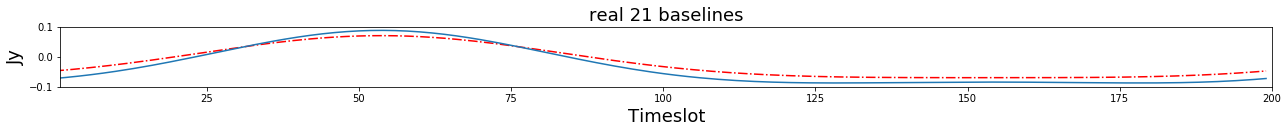

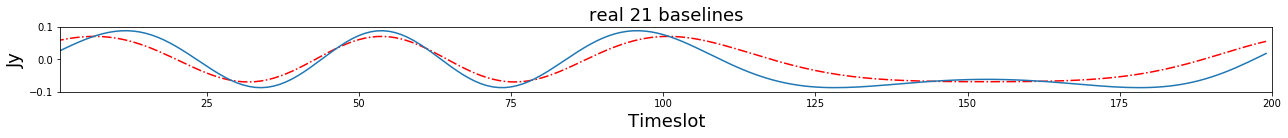

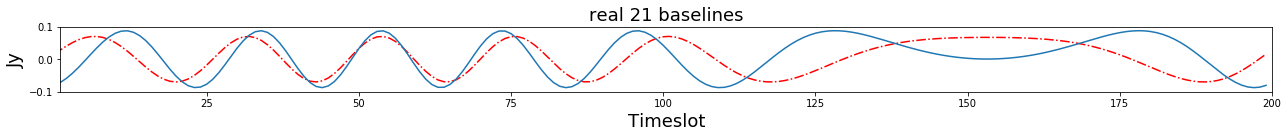

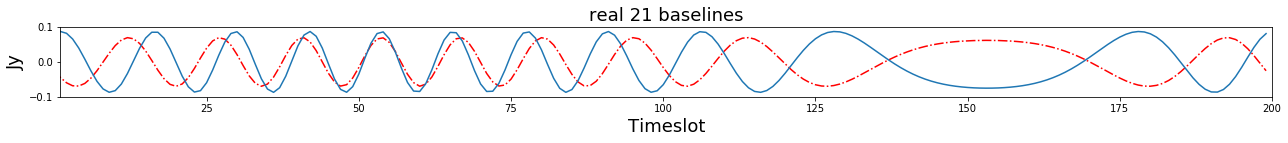

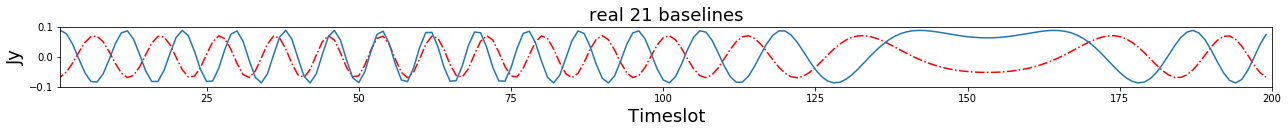

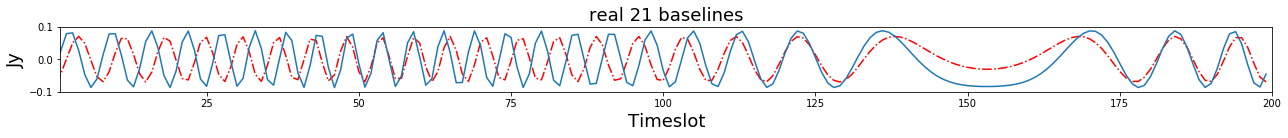

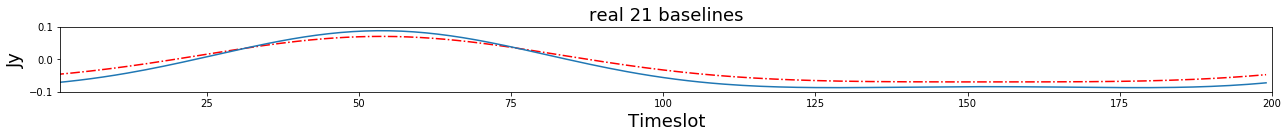

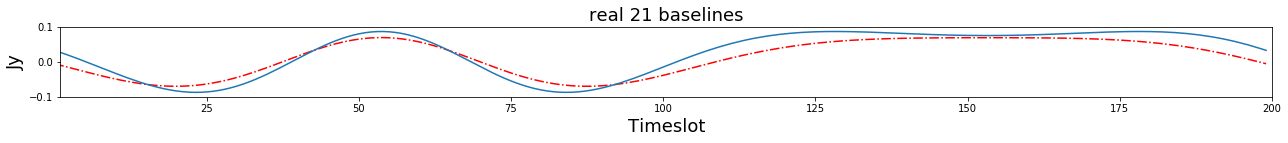

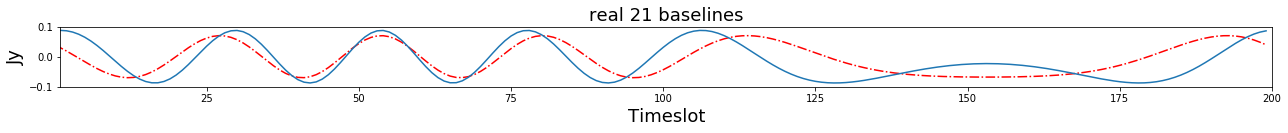

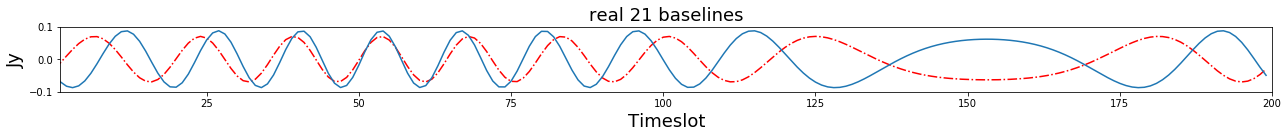

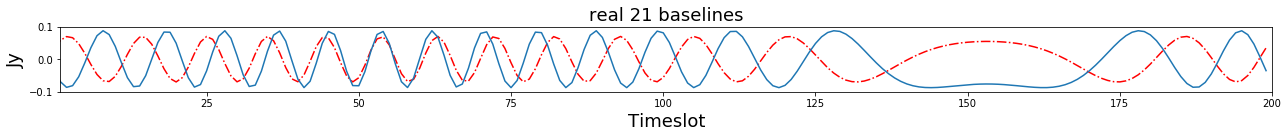

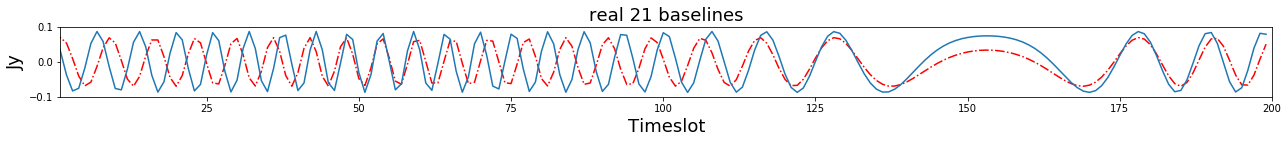

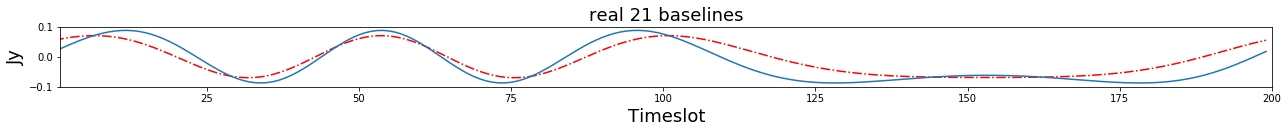

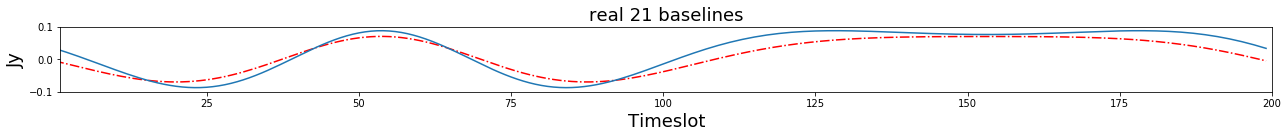

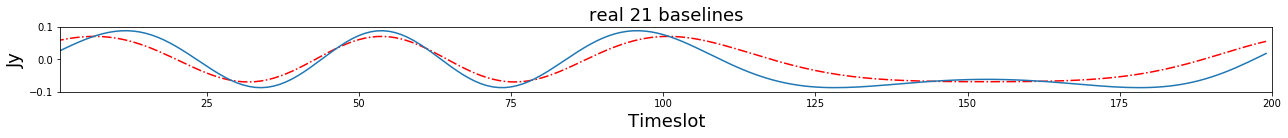

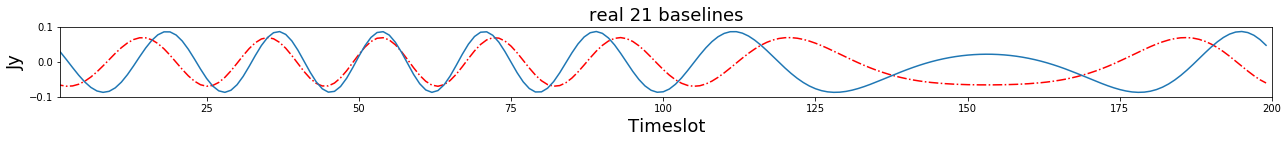

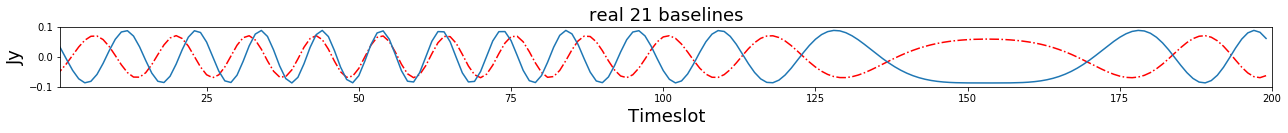

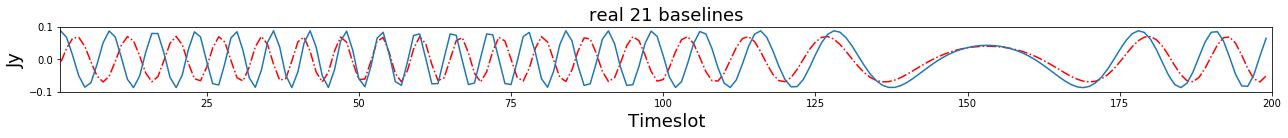

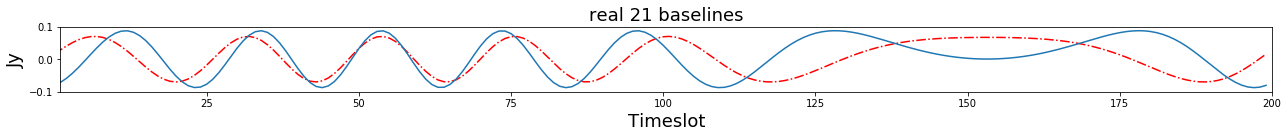

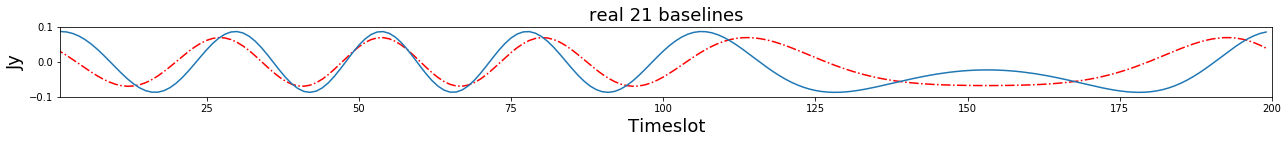

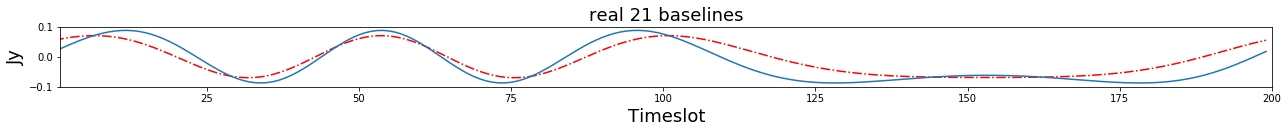

In [6]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("real {} baselines".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

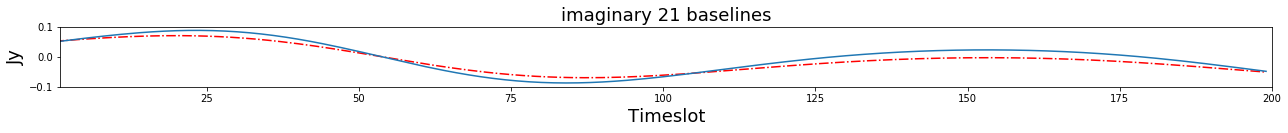

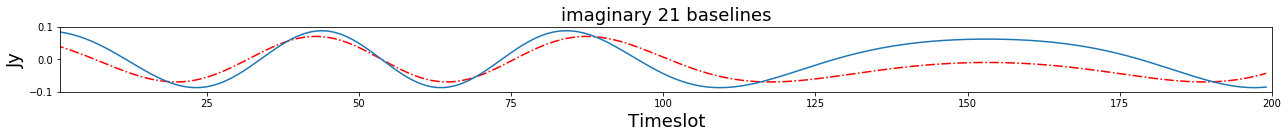

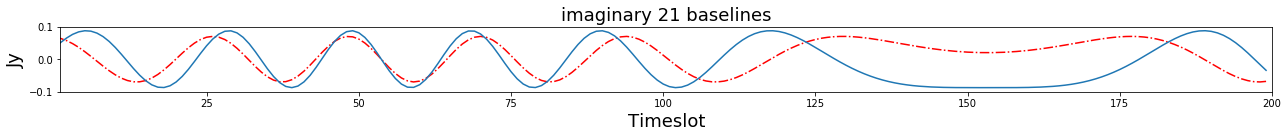

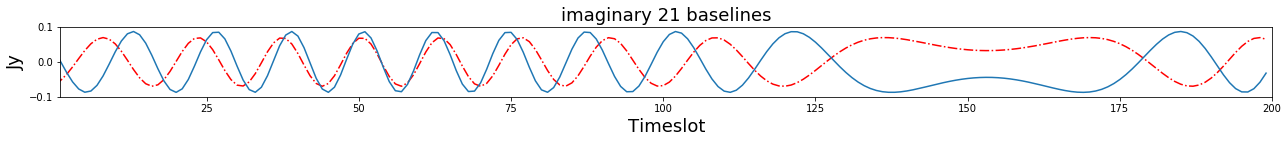

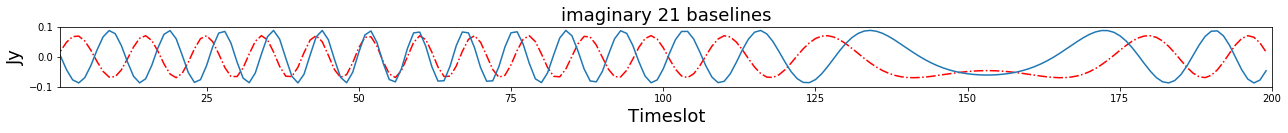

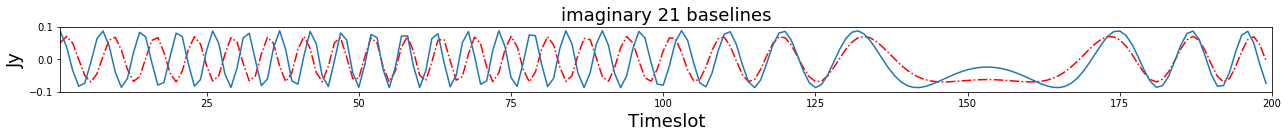

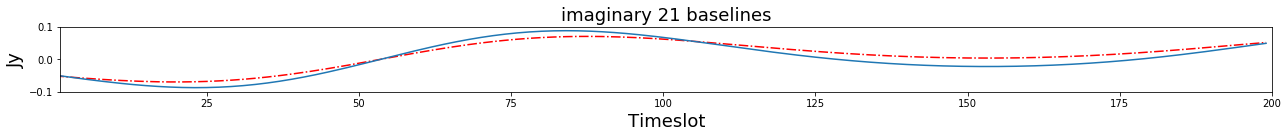

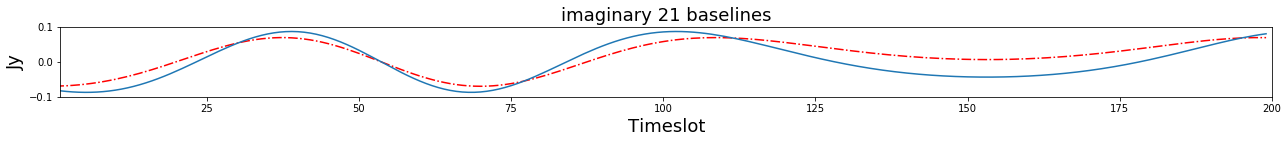

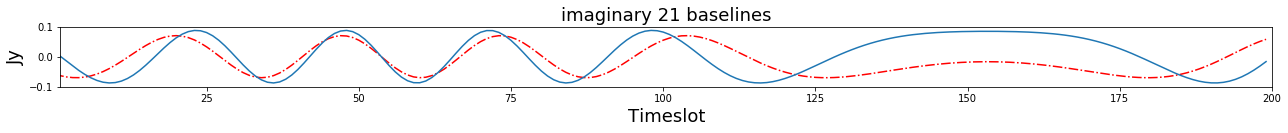

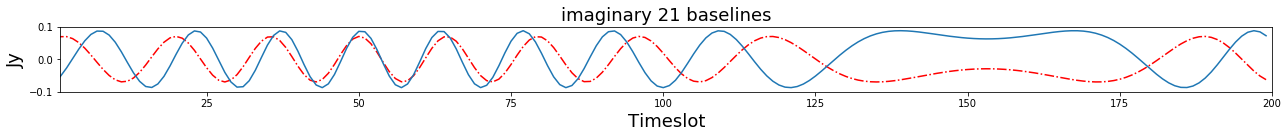

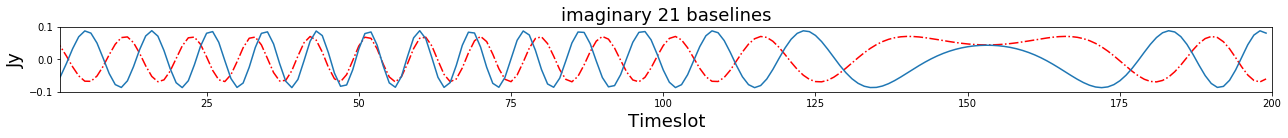

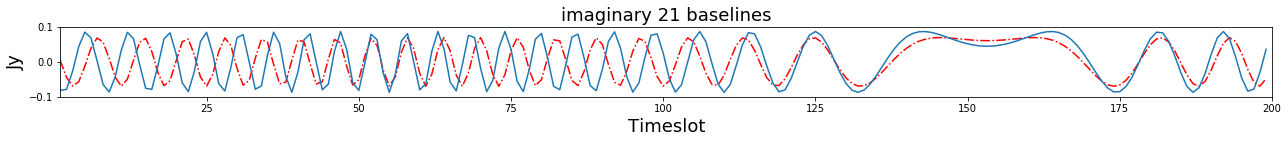

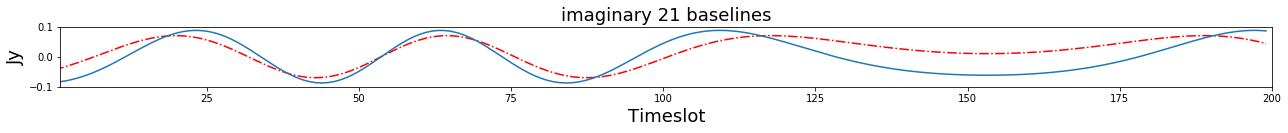

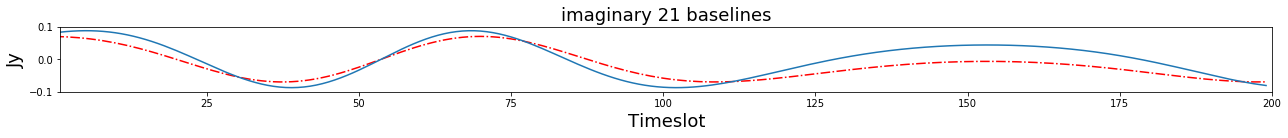

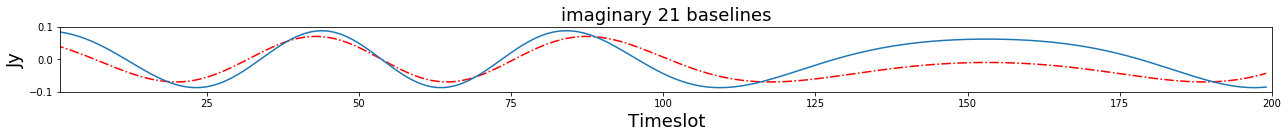

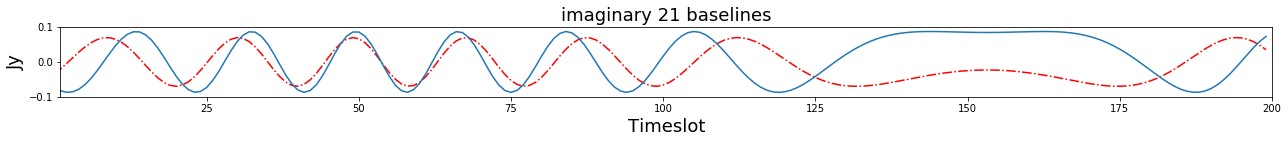

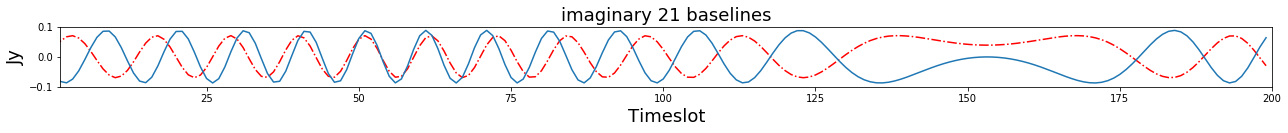

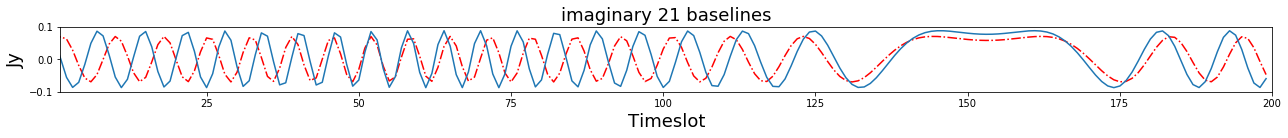

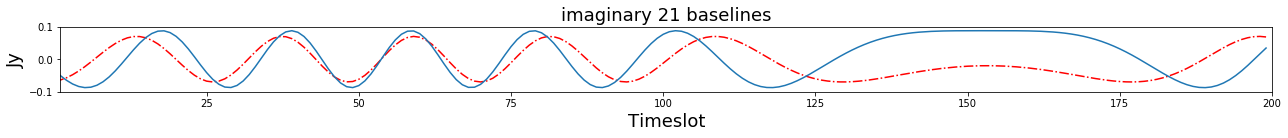

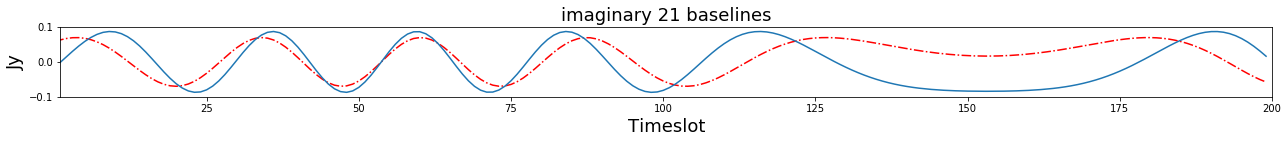

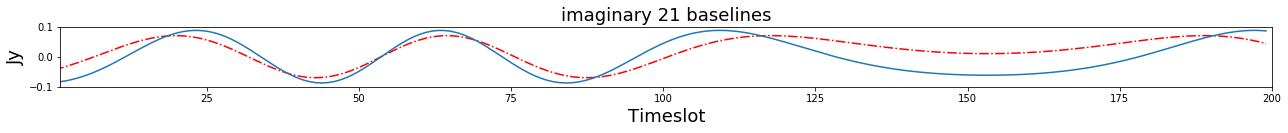

In [7]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("imaginary {} baselines".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

In [8]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    d         Vector of measured values.
    t         Value of independent variable at the sampled points. (300)
    x         Vector of parameters. (1,3)
    r_func    Function which generates the residual vector. (1,900)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (3,900) & (3,3) 
    maxiter   Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    
    r = r_func(x, u_ant, v_ant, data)
    print("Shape of residual vec: ", np.shape(r))
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0
    
    chiplot=[]
    chiplot.append(old_chi)
    
    solpath= x
    
    while True:
        
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        JH,JHJ = j_func(x,u_ant,v_ant)
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
        #lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)        
        x += delta_x.real
        
        solpath= np.vstack((solpath,x))        
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot,solpath


In [10]:
solved_x,cplot,spath = levenberg_marquardt(d,ut,vt,x_mod,pf.modfunc_res,pf.modfunc_jac)
print("solved x: ", solved_x)
print("true x: ", x_true)
print("model x: ",  x_start) #got from up there

Shape of residual vec:  (8400,)
solved x:  [ 0.00698132  0.00872665  0.06981311]
true x:  [ 0.00698132  0.00872665  0.06981317]
model x:  [ 0.00767945  0.00959931  0.08726646]


In [11]:
print(spath)
print(np.shape(spath))

[[ 0.00767045  0.00958823  0.05043643]
 [ 0.00767045  0.00958823  0.05043643]
 [ 0.0076551   0.00956931  0.03211617]
 [ 0.0076313   0.00953991  0.02311559]
 [ 0.00759779  0.00949837  0.01886269]
 [ 0.00755239  0.00944177  0.01710532]
 [ 0.0074869   0.00935964  0.01683235]
 [ 0.00737763  0.00922223  0.01800372]
 [ 0.00717457  0.00896743  0.0226866 ]
 [ 0.00695314  0.00869132  0.03851666]
 [ 0.00697852  0.00872314  0.05397457]
 [ 0.00698033  0.00872541  0.06189199]
 [ 0.00698089  0.00872611  0.06585234]
 [ 0.00698111  0.00872639  0.06783271]
 [ 0.00698122  0.00872652  0.06882293]
 [ 0.00698127  0.00872659  0.06931805]
 [ 0.00698129  0.00872662  0.06956561]
 [ 0.00698131  0.00872663  0.06968939]
 [ 0.00698131  0.00872664  0.06975128]
 [ 0.00698131  0.00872664  0.06978222]
 [ 0.00698132  0.00872664  0.0697977 ]
 [ 0.00698132  0.00872665  0.06980543]
 [ 0.00698132  0.00872665  0.0698093 ]
 [ 0.00698132  0.00872665  0.06981124]
 [ 0.00698132  0.00872665  0.0698122 ]
 [ 0.00698132  0.00872665

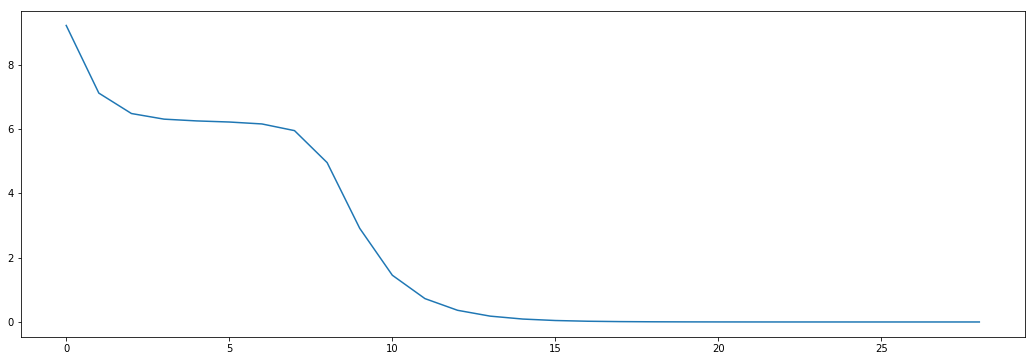

In [12]:
plt.plot(cplot)
plt.show()

In [14]:
L= np.radians(np.arange(-1,1,2/timeslots))
M= np.radians(np.arange(-1,1,2/timeslots))
A= np.radians(np.arange(1,11,10/timeslots))

rr_constA= np.empty((timeslots,timeslots))
rr_constM= np.empty((timeslots,timeslots))
rr_constL= np.empty((timeslots,timeslots))

for a in range(timeslots):
    for b in range(timeslots):
        
        x_r= [L[a],M[b],x_true[2]]
        rr_constA[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,ut,vt,d)))
        
for a in range(timeslots):
    for b in range(timeslots):
        
        x_r= [L[a],x_true[1],A[b]]
        rr_constM[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,ut,vt,d)))
        
for a in range(timeslots):
    for b in range(timeslots):
        
        x_r= [x_true[0],M[a],A[b]]
        rr_constL[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,ut,vt,d)))
        
Minimum_A= np.unravel_index(np.argmin(rr_constA),rr_constA.shape)
print("Minimum of (L,M) at: ", Minimum_A)
print(rr_constA[Minimum_A])

Minimum_M= np.unravel_index(np.argmin(rr_constM),rr_constM.shape)
print("Minimum of (L,A) at: ", Minimum_M)
print(rr_constM[Minimum_M])

Minimum_L= np.unravel_index(np.argmin(rr_constL),rr_constL.shape)
print("Minimum of (M,A) at: ",Minimum_L)
print(rr_constL[Minimum_L])

Minimum of (L,M) at:  (140, 150)
2.18050659836e-25
Minimum of (L,A) at:  (140, 60)
1.15481426131e-25
Minimum of (M,A) at:  (150, 60)
1.03532524881e-25


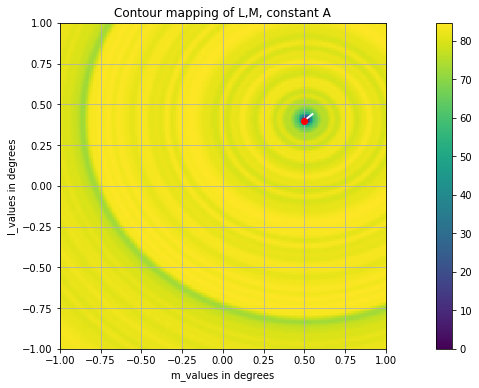

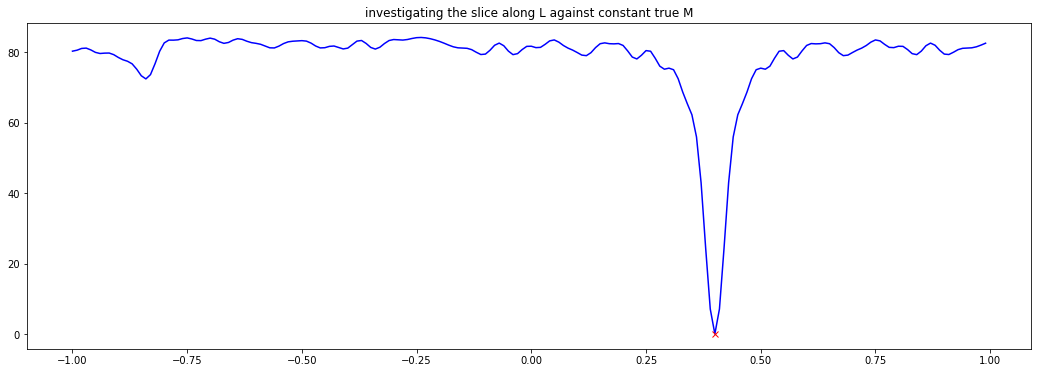

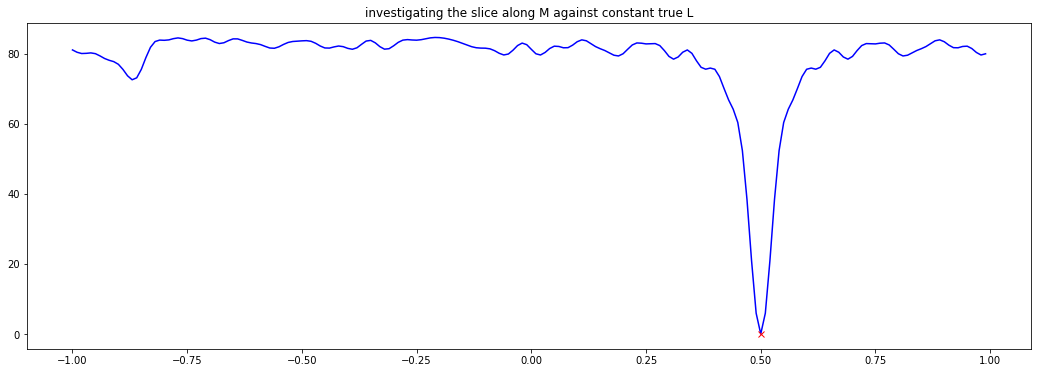

In [17]:
plt.imshow(np.flipud(rr_constA), extent=[-1,1,-1,1])
plt.plot(spath[:,1,]*180/np.pi, spath[:,0]*180/np.pi, 'w',lw=2)
plt.plot(x_true[1]*180/np.pi,x_true[0]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("m_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,M, constant A")
plt.show()

plt.plot(L*180/np.pi,rr_constA[:,Minimum_A[1]], 'b', x_true[0]*180/np.pi,[0],'rx')
plt.title("investigating the slice along L against constant true M")
plt.show()
plt.plot(M*180/np.pi,rr_constA[Minimum_A[0],:], 'b', x_true[1]*180/np.pi,[0],'rx')
plt.title("investigating the slice along M against constant true L")
plt.show()

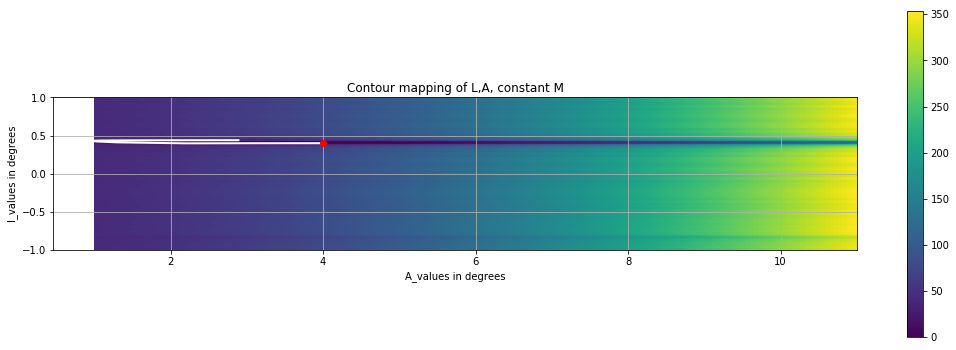

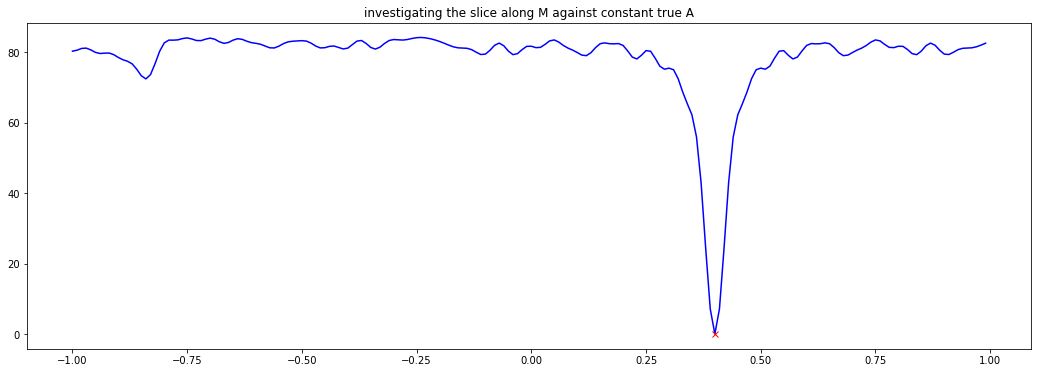

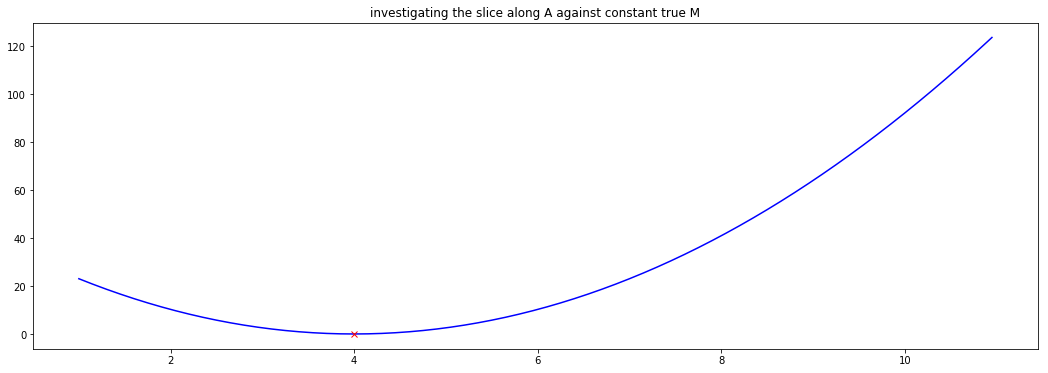

In [18]:
plt.imshow(np.flipud(rr_constM), extent=[1,11,-1,1])
plt.plot(spath[:,2]*180/np.pi, spath[:,0]*180/np.pi, 'w',lw=2)
plt.plot(x_true[2]*180/np.pi,x_true[0]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("A_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,A, constant M")
plt.show()

plt.plot(L*180/np.pi,rr_constM[:,Minimum_M[1]], 'b', x_true[0]*180/np.pi,[0],'rx')
plt.title("investigating the slice along M against constant true A")
plt.show()
plt.plot(A*180/np.pi,rr_constM[Minimum_M[0],:], 'b', x_true[2]*180/np.pi,[0],'rx')
plt.title("investigating the slice along A against constant true M")
plt.show()


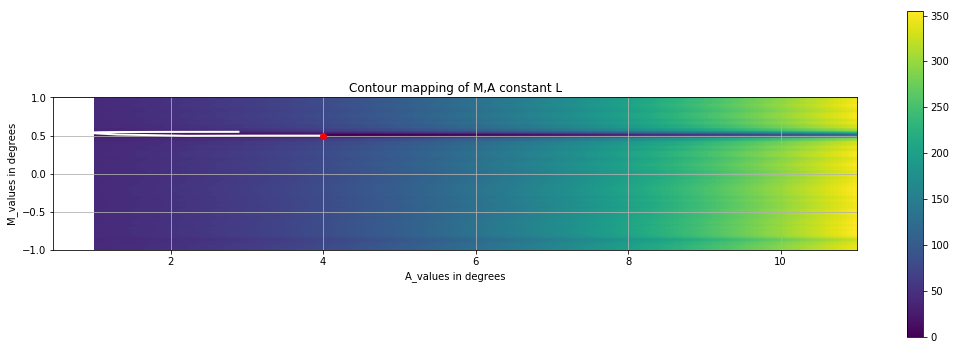

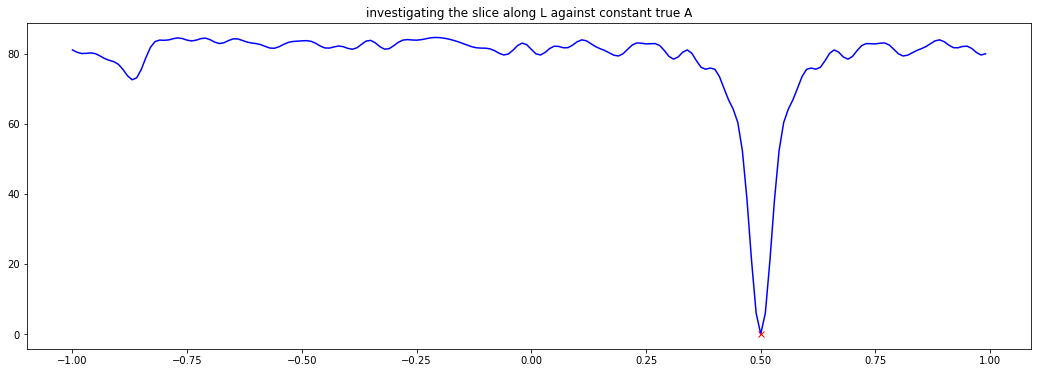

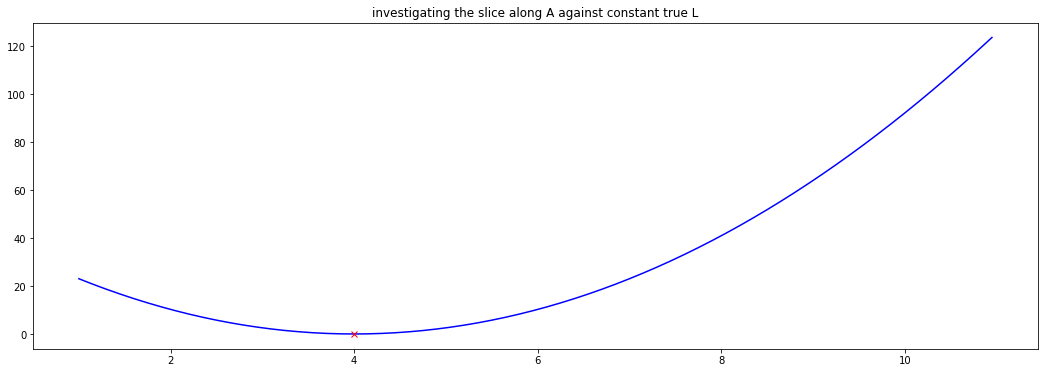

In [19]:
plt.imshow(np.flipud(rr_constL), extent=[1,11,-1,1])
plt.plot(spath[:,2]*180/np.pi, spath[:,1]*180/np.pi, 'w',lw=2)
plt.plot(x_true[2]*180/np.pi,x_true[1]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("A_values in degrees")
plt.ylabel("M_values in degrees")
plt.title("Contour mapping of M,A constant L")
plt.show()

plt.plot(M*180/np.pi,rr_constL[:,Minimum_L[1]], 'b', x_true[1]*180/np.pi,[0],'rx')
plt.title("investigating the slice along L against constant true A")
plt.show()
plt.plot(A*180/np.pi,rr_constL[Minimum_L[0],:], 'b', x_true[2]*180/np.pi,[0],'rx')
plt.title("investigating the slice along A against constant true L")
plt.show()


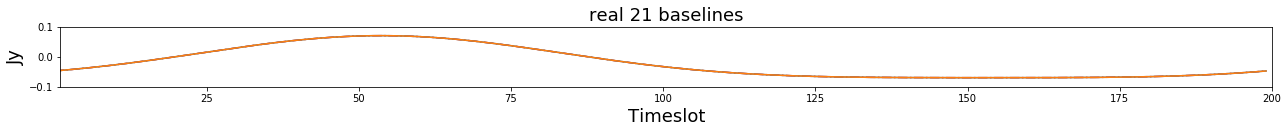

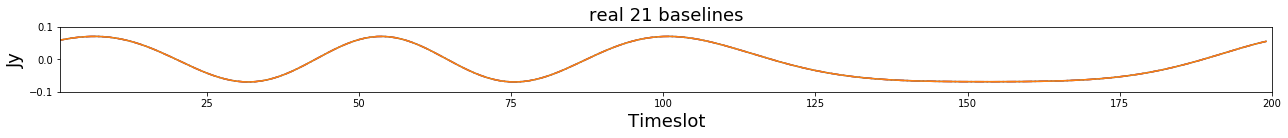

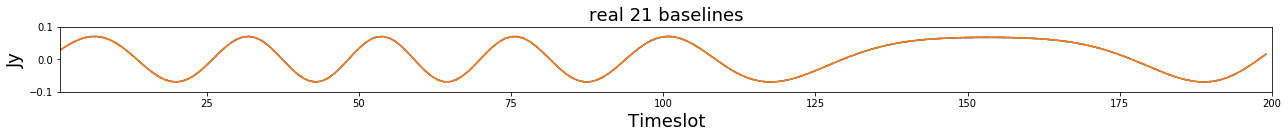

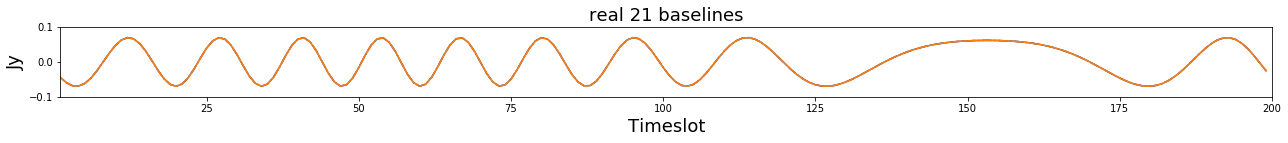

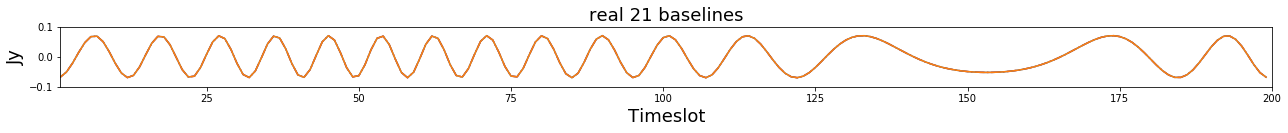

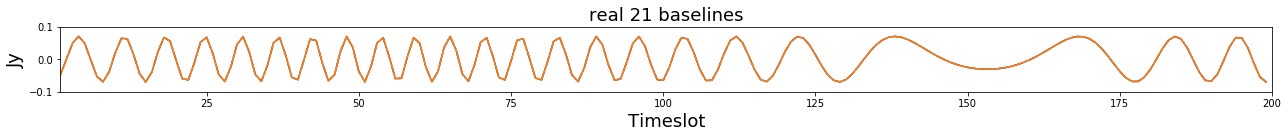

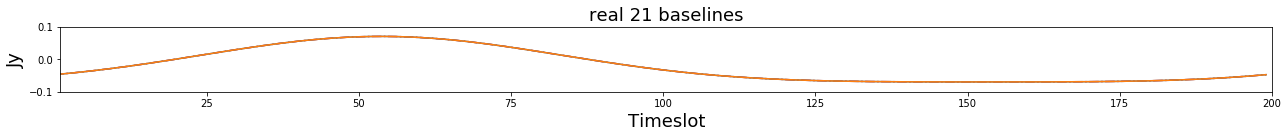

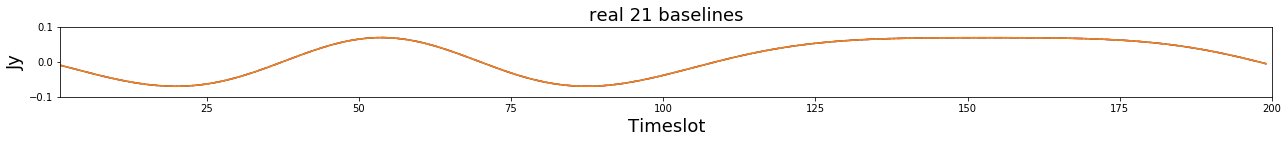

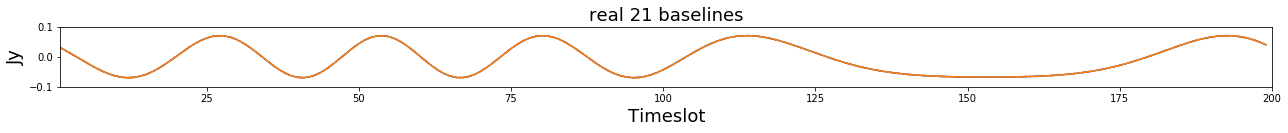

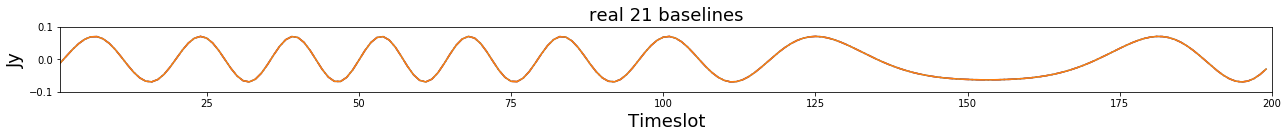

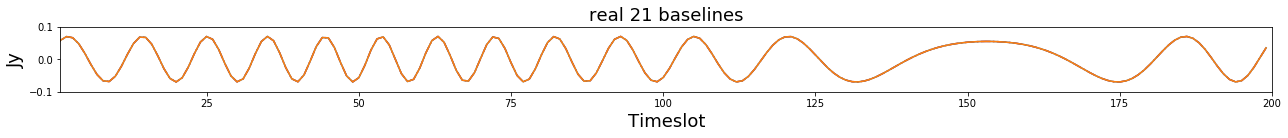

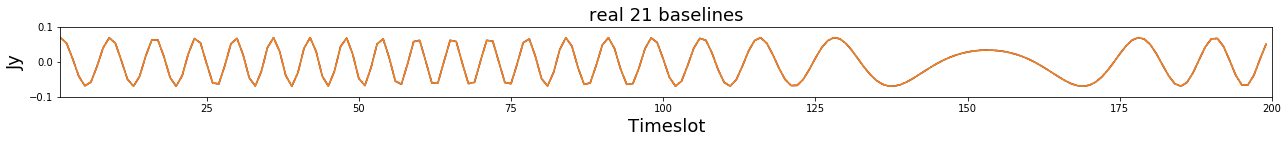

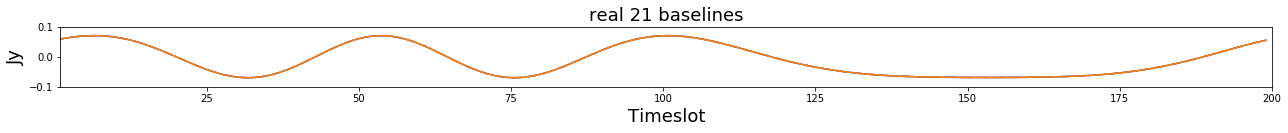

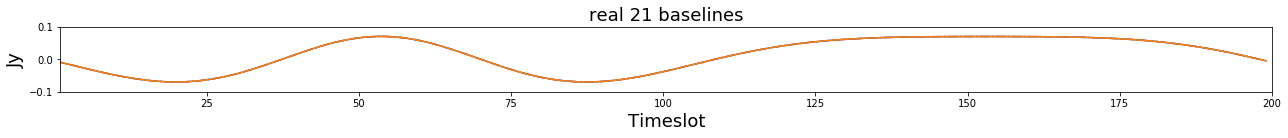

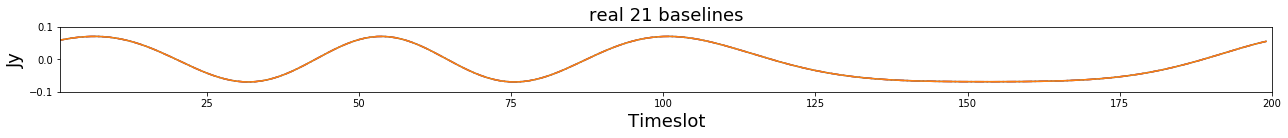

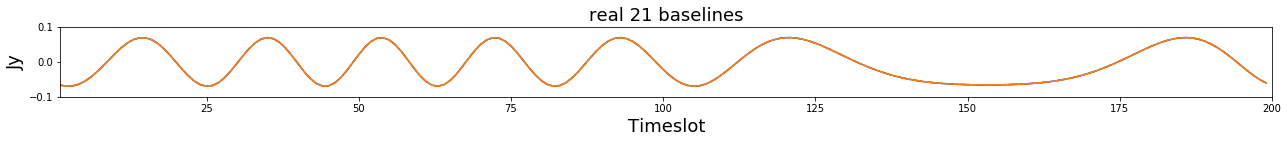

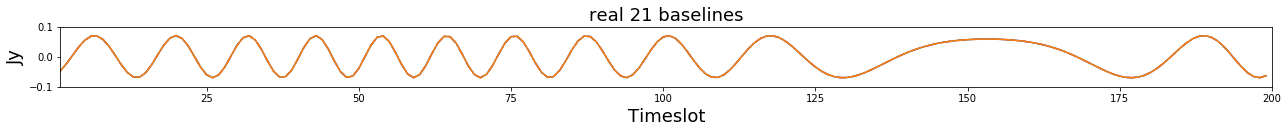

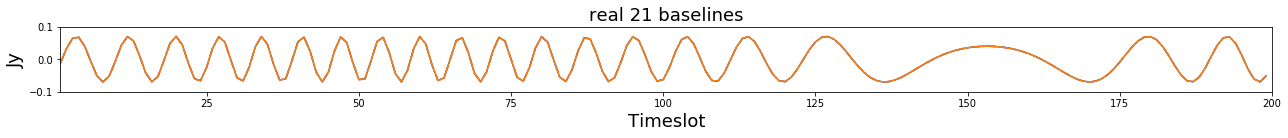

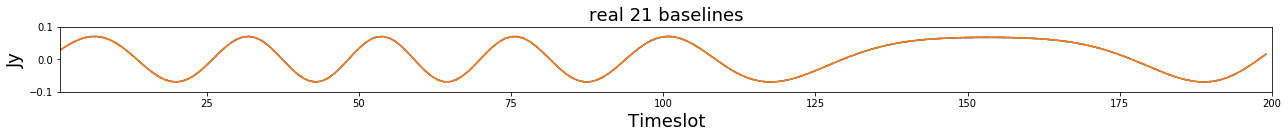

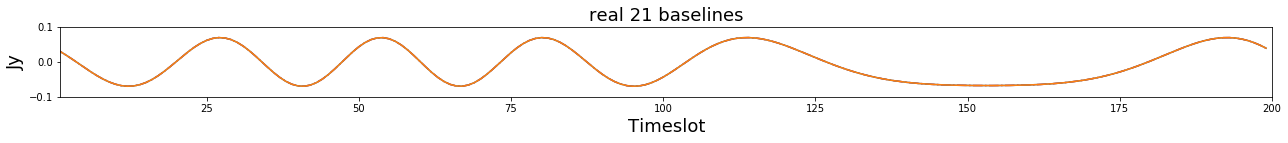

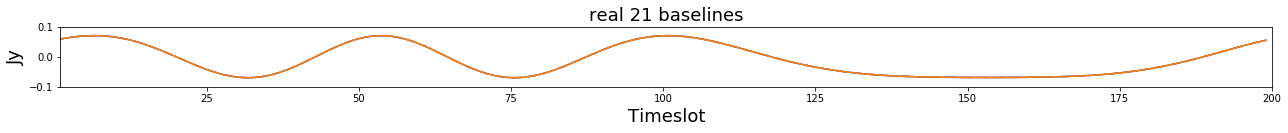

In [21]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("real {} baselines".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),pf.modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.plot(range(timeslots),pf.modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()


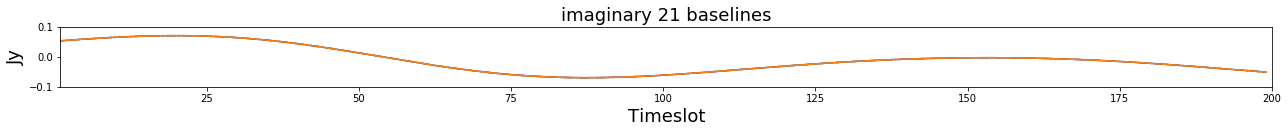

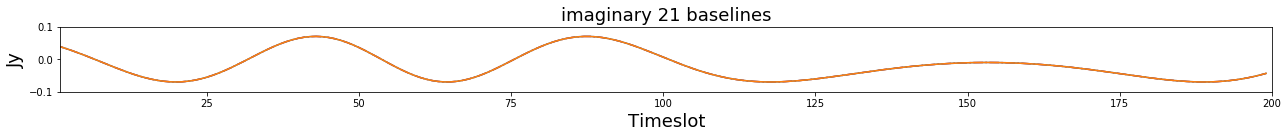

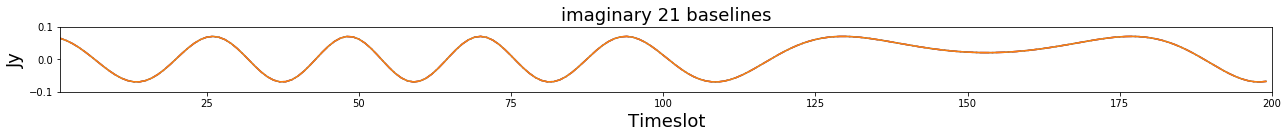

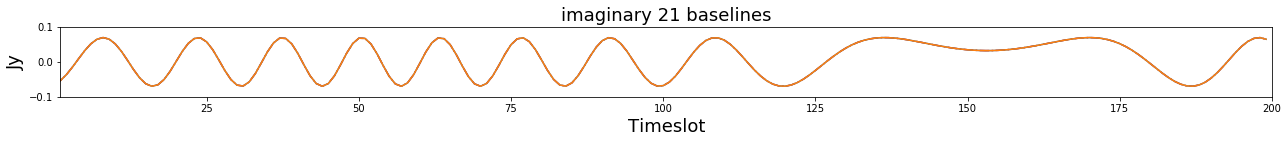

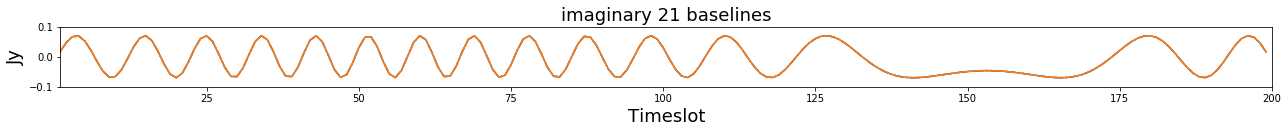

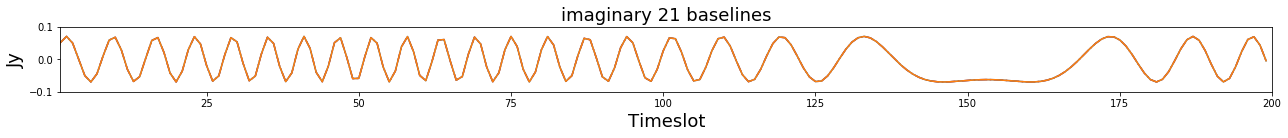

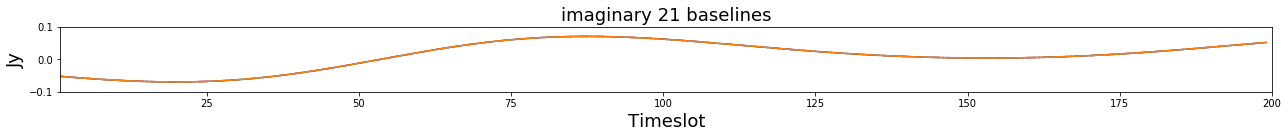

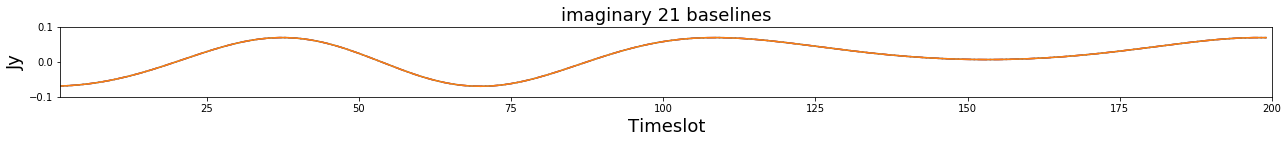

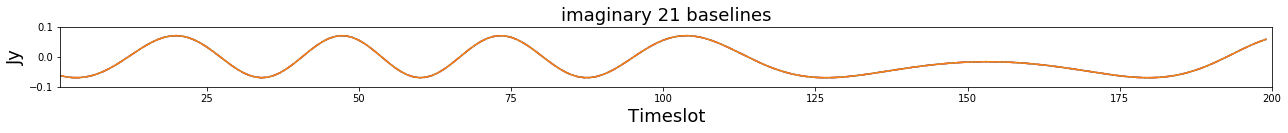

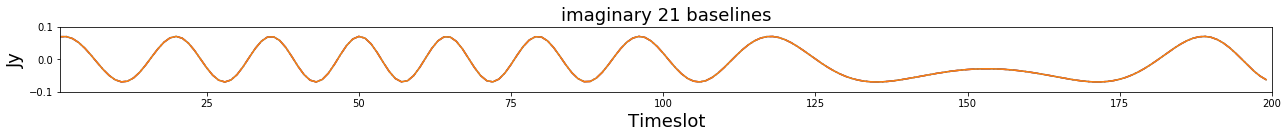

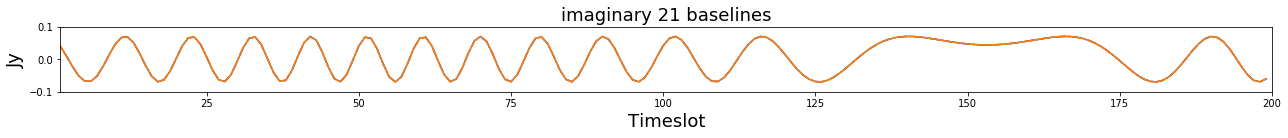

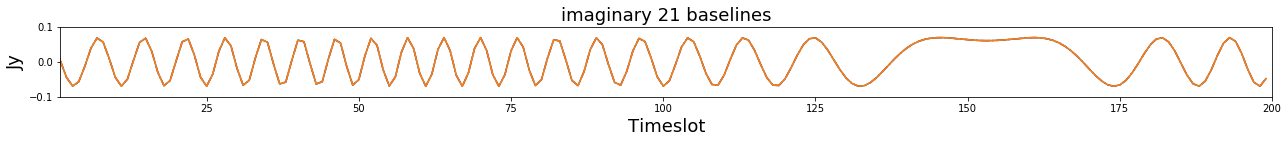

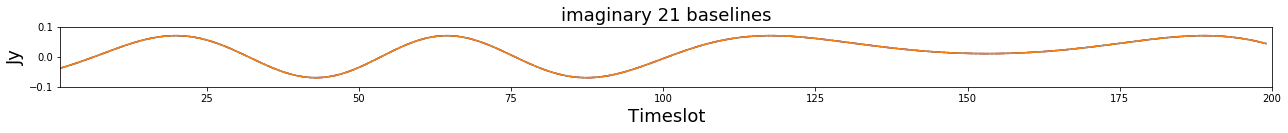

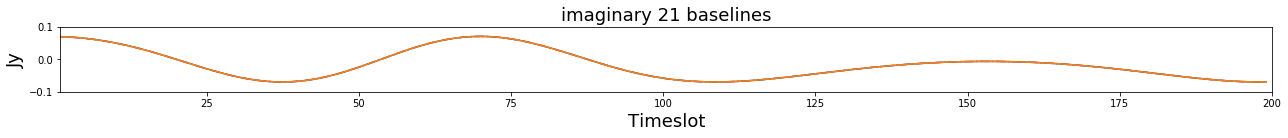

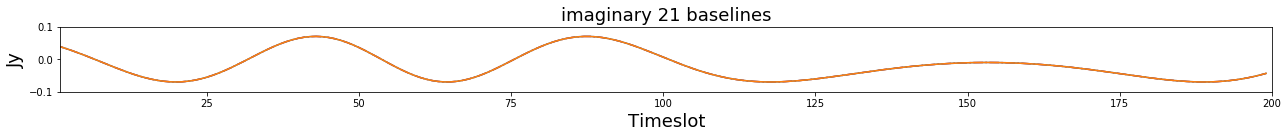

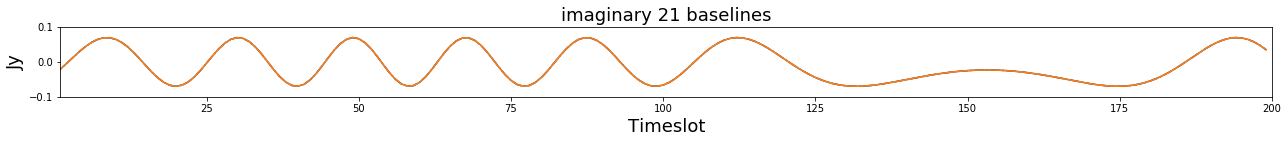

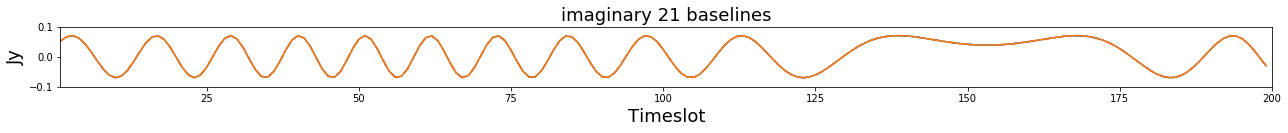

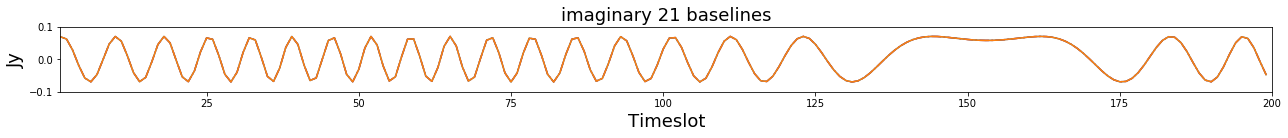

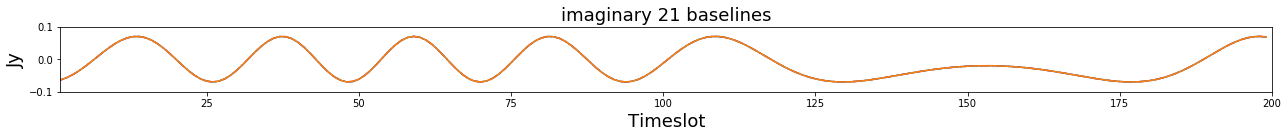

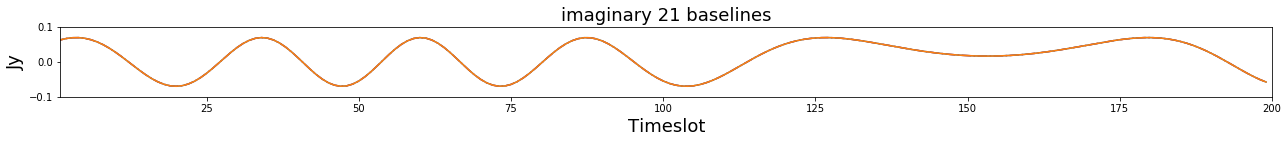

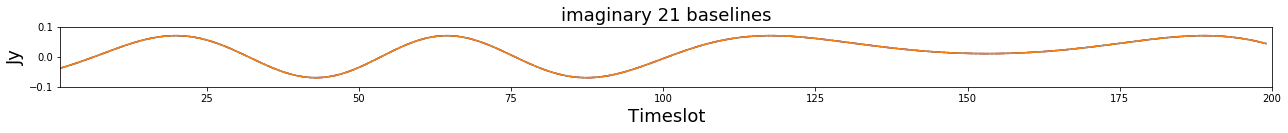

In [15]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("imaginary {} baselines".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),pf.modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.plot(range(timeslots),pf.modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

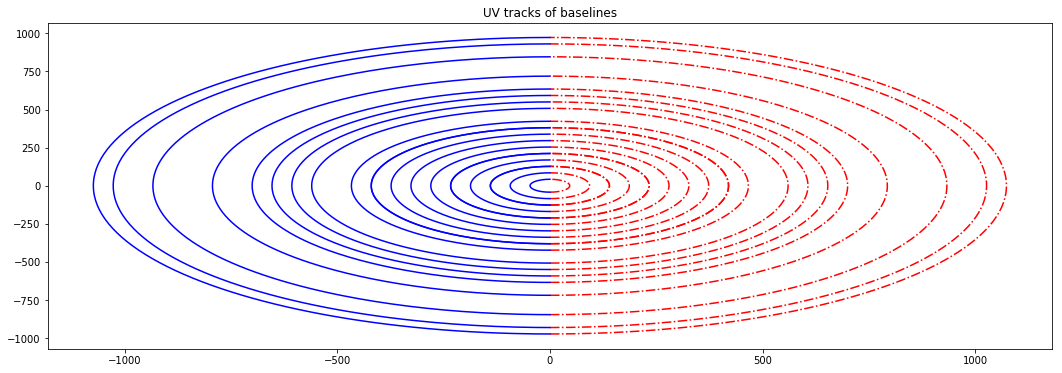

In [16]:
for k in range(len(ut)):
    for i in range(k,len(ut)):
        plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
        
plt.title("UV tracks of baselines")
plt.show()